# Loading Modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
T = transforms

In [ ]:
!pip install galaxy-datasets[pytorch]

The encoder and decoder are mirrored networks consisting of two layers. In the encoder the we take the input data to a hidden dimension through a linear layer and then we pass the hidden state to two different linear layers outputting the mean and standard deviation of the latent distribution respectively.

We then sample from the latent distribution and input it to the decoder that in turn outputs a vector of the same shape as the input.

# Building the VAE



In [ ]:
# creating helper print module
class PrintSize(nn.Module):
  def __init__(self):
    super(PrintSize, self).__init__()

  def forward(self, x):
    print(x.shape)
    return x

In [ ]:
from re import VERBOSE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim=200, kernel_size=4, hidden_channels=4,verbose=False):
        super().__init__()

        self.pool = nn.MaxPool2d(2, 2)

        # encoder

        # one for mu and one for stds, note how we only output
        # diagonal values of covariance matrix. Here we assume
        # the pixels are conditionally independent

        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size)
        self.conv2 = nn.Conv2d(hidden_channels, 1, kernel_size)
        self.vector_length = torch.math.floor((torch.math.floor((input_dim-(kernel_size-1)-1)/2)-(kernel_size-1)-1)/2)
        self.img_2hid = nn.Linear(self.vector_length**2, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, self.vector_length**2)
        #self.convt_a = nn.ConvTranspose2d(1, hidden_channels, kernel_size, stride=2, dilation=2)
        self.convt1 = nn.ConvTranspose2d(1, hidden_channels, kernel_size, stride=2, dilation=2)
        self.convt2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, stride=2,output_padding=1)
        self.convt3 = nn.ConvTranspose2d(hidden_channels, 1, kernel_size, stride=1,padding=2)
#####AlexNet Encoder:
        '''self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.linearlayer = nn.Linear(6400, 2809)'''
#####
    def encode(self, x):

        if verbose: print('X1 (e)',x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        if verbose: print('X2 (e)',x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        if verbose: print('X3 (e)',x.shape)
        x = torch.flatten(x, 1)
        if verbose: print('X4 (e)',x.shape)
        '''out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = torch.flatten(out,1)
        print('Out shape',out.shape)
        x =  self.linearlayer(out)'''
        h = F.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        new_h = F.relu(self.z_2hid(z))
        x = self.hid_2img(new_h)
        if verbose: print('X1 (d)',x.shape) #torch.Size([3, 2809])
        x = x.reshape(z.shape[0], 1, self.vector_length, self.vector_length)
        if verbose: print('X2 (d)',x.shape) #torch.Size([3, 1, 53, 53])
        x = F.relu(self.convt1(x))
#        if verbose: print('Xa (d)',x.shape) #torch.Size([3, 3, 111, 111])
#        x = F.relu(self.convt_a(x))
        if verbose: print('X3 (d)',x.shape)
        x = F.relu(self.convt2(x))
        if verbose: print('X4 (d)',x.shape)
        x = F.relu(self.convt3(x))
        return x

    def forward(self, x):
        mu, sigma = self.encode(x)
        # Sample from latent distribution from encoder
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        x = self.decode(z_reparametrized)
        return x, mu, sigma

global verbose
verbose=True


In [ ]:
VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=3).forward(torch.randn([3,1,100,100]))[2]


tensor([[-0.0029,  0.1188, -0.1439,  0.0056,  0.0006, -0.0927,  0.1340, -0.0348],
        [-0.0633,  0.0994, -0.1825,  0.0556,  0.0201, -0.0270,  0.1202, -0.1198],
        [-0.0437,  0.1166, -0.1059,  0.0378,  0.0398,  0.1058,  0.0464, -0.1300]],
       grad_fn=<AddmmBackward0>)

# VAE Configuration

In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 224
Z_DIM = 8
H_DIM = 112
NUM_EPOCHS = 5
BATCH_SIZE = 132
LR_RATE = 1e-3

# Loading the Data

In [ ]:
# Dataset loading
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
# train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
from galaxy_datasets import gz2  # or gz_hubble, gz_candels, ...

catalog, label_cols = gz2(root='gz2',train=True,download=False)

In [ ]:
catalog[catalog['label']==3]

,ra,dec,smooth-or-featured-gz2_smooth,smooth-or-featured-gz2_featured-or-disk,smooth-or-featured-gz2_artifact,disk-edge-on-gz2_yes,disk-edge-on-gz2_no,bar-gz2_yes,bar-gz2_no,has-spiral-arms-gz2_yes,...,something-odd-gz2_semantic,how-rounded-gz2_semantic,bulge-shape-gz2_semantic,spiral-winding-gz2_semantic,spiral-arm-count-gz2_semantic,summary,leaf_prob,label,filename,id_str
34,171.237823,8.361594,21,31,1,18,12,2,11,7,...,something-odd-gz2_no,-,-,-,-,edge_on_disk,0.350943,3,587732703944441947.jpg,587732703944441947
189,208.289093,51.812511,16,21,0,21,0,0,0,0,...,something-odd-gz2_no,-,deadlock,-,-,edge_on_disk,0.567568,3,587733079745560618.jpg,587733079745560618
427,225.136414,49.174316,2,39,1,39,0,0,0,0,...,something-odd-gz2_no,-,bulge-shape-gz2_round,-,-,edge_on_disk,0.928571,3,587735664773103746.jpg,587735664773103746
445,137.488968,16.593647,24,26,0,19,7,1,6,5,...,something-odd-gz2_no,-,-,-,-,edge_on_disk,0.380000,3,588023238596821102.jpg,588023238596821102
517,239.106964,29.070280,12,35,0,34,1,1,0,1,...,something-odd-gz2_no,-,bulge-shape-gz2_round,-,-,edge_on_disk,0.723404,3,587736620397756601.jpg,587736620397756601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167128,233.340546,4.933946,20,28,0,28,0,0,0,0,...,something-odd-gz2_no,-,bulge-shape-gz2_round,-,-,edge_on_disk,0.583333,3,587736546314682749.jpg,587736546314682749
167164,251.546478,29.116310,18,32,1,19,13,1,12,8,...,something-odd-gz2_no,-,-,-,-,edge_on_disk,0.372549,3,587733398113288457.jpg,587733398113288457
167175,199.114212,15.798174,13,26,0,26,0,0,0,0,...,something-odd-gz2_no,-,bulge-shape-gz2_no-bulge,-,-,edge_on_disk,0.666667,3,587742772956102721.jpg,587742772956102721
167332,154.231934,44.519592,13,29,1,30,0,0,0,0,...,something-odd-gz2_no,-,bulge-shape-gz2_round,-,-,edge_on_disk,0.674419,3,587732151498244153.jpg,587732151498244153


In [ ]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
catalog['summary_val']=catalog['summary'].map({'smooth_round':1,'smooth_inbetween':2,'smooth_cigar':3,\
                                             'featured_without_bar_or_spiral':4,'edge_on_disk':5,'barred_spiral':6,\
                                             'unbarred_spiral':7,None:8})

datamodule = GalaxyDataModule(
    catalog=catalog[catalog['summary_val']==1].sample(20000,replace=False),#,catalog.sample(20000),
    label_cols =[])

datamodule.prepare_data()
datamodule.setup()

train_data = datamodule.train_dataloader()
val_data = datamodule.val_dataloader()


GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Training the Model

In [ ]:
def early_stopping(train_loss, validation_loss, min_delta_frac):
    val_train_diff = (validation_loss - train_loss)/train_loss
    if  val_train_diff > min_delta_frac:
          print('Fractional Difference',val_train_diff)
          return True

# Define train function
def train(num_epochs, model, optimizer, loss_fn, training_dataloader,val_dataloader,start_epoch = 0,save_path='./', kl_div_multi=5e-4):
    # Start training
    train_loss_list = [];val_loss_list=[]
    for epoch in np.arange(start_epoch,num_epochs):
        train_loss_per_epoch=[];
        loop = tqdm(enumerate(training_dataloader), total=len(training_dataloader))
        print(f'epoch number = {epoch}')
        for i, (x, _) in loop:
            x = T.CenterCrop(size=[100,100])(x)
            # Forward pass
            x_reconst, mu, sigma = model(x.to(device))
            n_dim = mu.shape[0]
            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss = loss_fn(x_reconst, x.to(device))
            kl_div = - torch.mean(1 + torch.sum(torch.log(sigma.pow(2)), 1) - torch.linalg.vector_norm(mu, dim=1) - torch.sum(sigma.pow(2), 1))
#
            # x_val = datamodule.val_dataloader().to(device).view(-1, INPUT_DIM)
            # x_reconst_val,mu_val,sigma_val = model(x_val)
            # reconst_loss_val = torch.sum((x_reconst - x_val).pow(2))
            # kl_div_val = - torch.sum(1 + torch.log(sigma_val.pow(2)) - mu_val.pow(2) - sigma_val.pow(2))
            # loss_val = torch.mean(reconst_loss_val + kl_div_val)
            # Backprop and optimize
            loss = reconst_loss + kl_div*kl_div_multi
            # if early_stopping(loss, val_loss, min_delta_frac=0.1):
            #     print(f'Early stopping at epoch/loss/val_loss {epoch,loss,val_loss}')
            #     break
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
#            train_loss_list.append(loss)
 #           print('NPY LOSS',loss.numpy(),dir(loss))
            loss_npy = loss.cpu().detach().numpy()
            train_loss_per_epoch.append(loss_npy)
            loop.set_postfix({'loss': loss_npy})
            # if len(train_loss_per_epoch)%100==0:
            #       print(f'Current Loss {train_loss_per_epoch[-1]}')
        with torch.no_grad():
            val_loss_per_epoch=[]
            for j, (x_val,_) in enumerate(val_dataloader):
                x_val = T.CenterCrop(size=[100,100])(x_val)
                # validation
                x_reconst_val,mu_val,sigma_val = model(x_val.to(device))
                reconst_loss_val = loss_fn(x_reconst_val, x_val.to(device))
                kl_div_val = - torch.mean(1 + torch.sum(torch.log(sigma_val.pow(2)),1) - torch.linalg.vector_norm(mu_val, dim=1) - torch.sum(sigma_val.pow(2), 1))
    #                reconst_loss_val = torch.sum((x_reconst - x_val).pow(2))
    #                kl_div_val = -torch.mean(1 + torch.log(torch.linalg.vector_norm(sigma_val)) - torch.linalg.vector_norm(mu_val) - torch.linalg.vector_norm(sigma_val))
                val_loss = reconst_loss_val + kl_div_val*kl_div_multi
                val_loss_per_epoch.append(val_loss.cpu().detach().numpy())
        train_loss_list.append(np.mean(train_loss_per_epoch))
        val_loss_list.append(np.mean(val_loss_per_epoch))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': np.mean(train_loss_per_epoch),
            'val_loss':np.mean(val_loss_per_epoch)},\
            save_path+'_'+str(epoch)+'.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Actually Training/Loading Model

In [ ]:
# Initialize model, optimizer, loss
INPUT_DIM=100
model = VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.MSELoss(reduction="mean")
# Run training

load_epoch_n = 13
checkpoint = torch.load('/content/drive/MyDrive/VAE_on_blobs_'+str(load_epoch_n)+'.pth',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['train_loss']

NUM_EPOCHS=20
global verbose
verbose=False

In [ ]:
train(NUM_EPOCHS, model, optimizer, loss_fn, train_data,val_data,start_epoch=load_epoch_n+1,\
      save_path = '/content/drive/MyDrive/VAE_on_blobs')

  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 0


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 1


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 2


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 3


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 4


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 5


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 6


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 7


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 8


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 9


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 10


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 11


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 12


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 13


  0%|          | 0/55 [00:00<?, ?it/s]

epoch number = 14


 22%|██▏       | 12/55 [00:30<01:48,  2.52s/it, loss=90.87653]


KeyboardInterrupt: ignored

In [ ]:
trial_data = next(iter(train_data))

In [ ]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_sta

# Plotting Generated Images

In [ ]:
#trial_data = next(iter(train_data))
# import torchvision.transforms as T
abc = T.CenterCrop(size=[100,100])(trial_data[0]).cpu().detach().numpy()
for i in range(4):
  plt.imshow(abc[i,0,:,:])
  plt.show()

In [ ]:
trial_data = next(iter(train_data))
trial_data_sample_cropped = T.CenterCrop(size=[100,100])(trial_data[0])
trial_batch = model(trial_data_sample_cropped.to(device))[0].cpu().detach().numpy()

In [ ]:
for im_number in np.arange(10):
  fig,ax = plt.subplots(1,2,figsize= (10,5))
  ax[0].imshow(trial_data_sample_cropped.detach().numpy()[im_number,0,:,:])
  ax[1].imshow(trial_batch[im_number,0,:,:])
  plt.show()

In [ ]:
test_data = datamodule.test_dataloader()
trial_data = next(iter(test_data))
trial_data_sample_cropped = T.CenterCrop(size=[100,100])(trial_data[0])
trial_batch = model(trial_data_sample_cropped.to(device))[0].cpu().detach().numpy()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for im_number in np.arange(10):
  fig,ax = plt.subplots(1,2,figsize= (10,5))
  ax[0].imshow(trial_data_sample_cropped.detach().numpy()[im_number,0,:,:])
  ax[1].imshow(trial_batch[im_number,0,:,:])
  plt.show()

In [ ]:
model(trial_data_sample_cropped.to(device))[1].cpu().detach().numpy()[0]

array([-269.757    , -886.507    ,   -5.8096256,  -74.533875 ,
        -61.530598 ,  -45.5604   ,  -86.65844  ,  -49.55056  ],
      dtype=float32)

In [ ]:
model(trial_data_sample_cropped.to(device))[2].cpu().detach().numpy()[0]

array([-0.12494011,  0.56983495, -1.1911994 , -3.9802575 ,  0.41380253,
       -5.809296  , -0.5401455 ,  1.5305221 ], dtype=float32)

# Loss Plots

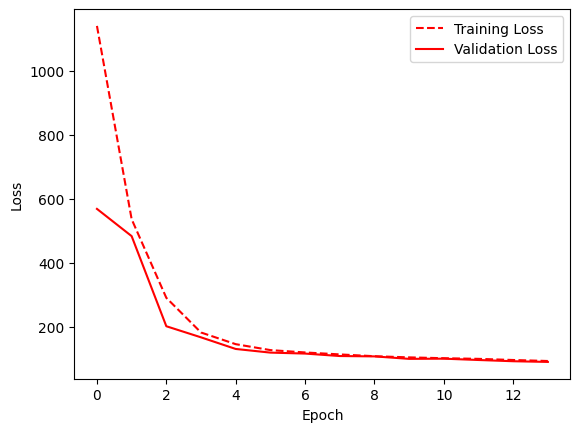

In [ ]:
v_loss_list = []
t_loss_list = []
for i in range(14):
    checkpoint = torch.load('/content/drive/MyDrive/VAE_on_blobs_'+str(i)+'.pth',map_location=torch.device('cpu'))
    t_loss_list.append(checkpoint['train_loss'])
    v_loss_list.append(checkpoint['val_loss'])

plt.plot(t_loss_list,'--',c='red')
plt.plot(v_loss_list,c='red')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.show()

In [ ]:
ls '/content/drive/MyDrive/Colab Notebooks/'

'Copy of [Qin] VAE Code (1).ipynb'   VAE_weights_conv_Cropped_3.pth
 VAE_weights_conv_Cropped/           VAE_weights_conv_Cropped_4.pth
 VAE_weights_conv_Cropped_0.pth      VAE_weights_conv_Cropped_5.pth
 VAE_weights_conv_Cropped_1.pth      VAE_weights_conv_Cropped_6.pth
 VAE_weights_conv_Cropped_2.pth      VAE_weights_conv_Cropped_7.pth


# Reconstruction Error

In [ ]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
catalog['summary_val']=catalog['summary'].map({'smooth_round':1,'smooth_inbetween':2,'smooth_cigar':3,\
                                             'featured_without_bar_or_spiral':4,'edge_on_disk':5,'barred_spiral':6,\
                                             'unbarred_spiral':7,None:8})

datamodule_ve = GalaxyDataModule(
    catalog=catalog[catalog['summary_val']==3].sample(10000,replace=False),label_cols =[])

datamodule_ve.prepare_data()
datamodule_ve.setup()

test_data_ve = datamodule_ve.test_dataloader()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_data = datamodule.test_dataloader()
trial_data = next(iter(test_data))
trial_data_sample_cropped = T.CenterCrop(size=[100,100])(trial_data[0])
trial_batch = model(trial_data_sample_cropped.to(device))[0].cpu().detach().numpy()
reconstruct_error_train = []
for im_number in np.arange(len(trial_batch)):
  orig = trial_data_sample_cropped.detach().numpy()[im_number,0,:,:]
  modelled = trial_batch[im_number,0,:,:]
  reconstruct_error_train.append(np.sum((orig-modelled)**2))




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Latent Space Representation

In [ ]:
mu_test = VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=3).forward(trial_data_sample_cropped)[1]
sigma_test = VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=3).forward(trial_data_sample_cropped)[2]

mu_ve = VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=3).forward(ve_data_sample_cropped)[1]
sigma_ve = VariationalAutoEncoder(INPUT_DIM, Z_DIM,hidden_channels=3).forward(ve_data_sample_cropped)[2]

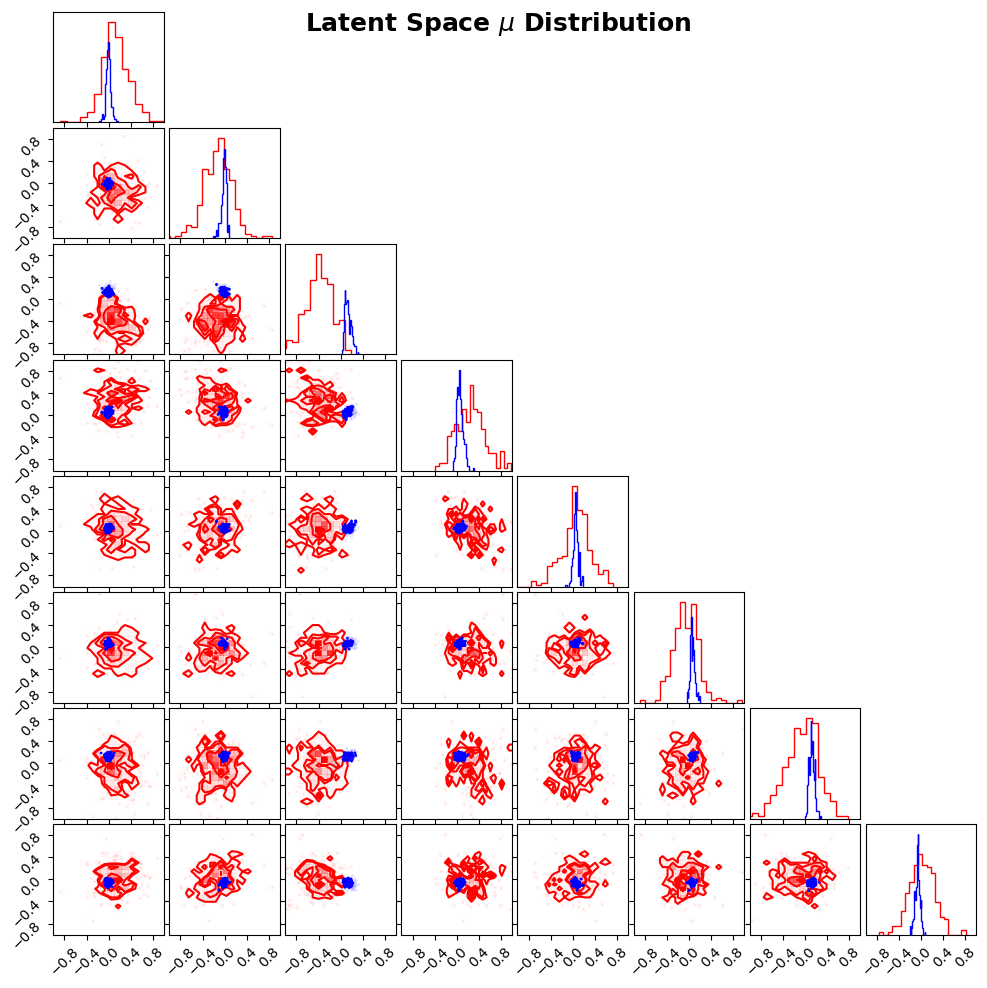

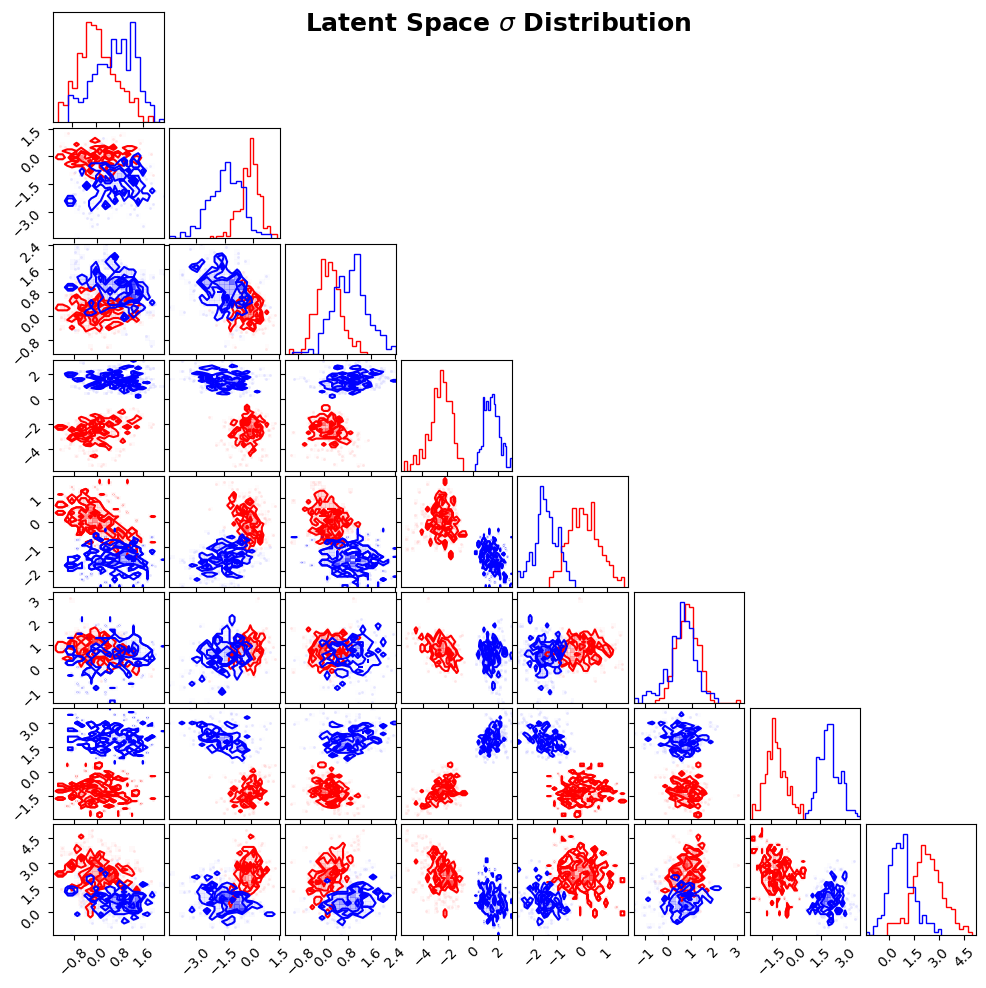

In [ ]:
#!pip install corner#
import corner
fig,ax = plt.subplots(8,8,figsize=(10,10))
corner.corner(mu_test.detach().numpy(),fig=fig,color='red')
corner.corner(mu_ve.detach().numpy(),fig=fig,color='blue')
for i in range(8):
  for j in range(8):
    try:
      ax[i,j].set_xlim(-1,1)
      if i!=j: ax[i,j].set_ylim(-1,1)
    except:
      pass
plt.suptitle('Latent Space $\mu$ Distribution',fontsize=18,fontweight='bold')
plt.show()

fig,ax = plt.subplots(8,8,figsize=(10,10))
corner.corner(sigma_test.detach().numpy(),fig=fig,color='red')
corner.corner(sigma_ve.detach().numpy(),fig=fig,color='blue')
#for i in range(8):
#  for j in range(8):
#    try:
#      ax[i,j].set_xlim(-1,1)
#      if i!=j: ax[i,j].set_ylim(-1,1)
#    except:
#      pass
plt.suptitle('Latent Space $\sigma$ Distribution',fontsize=18,fontweight='bold')
plt.show()

In [ ]:
#trial_data_ve = next(iter(test_data_ve))

ve_data_sample_cropped = T.CenterCrop(size=[100,100])(trial_data_ve[0])
ve_batch = model(ve_data_sample_cropped.to(device))[0].cpu().detach().numpy()
reconstruct_error_ve = []
for im_number in np.arange(len(ve_batch)):
  orig_ve = ve_data_sample_cropped.detach().numpy()[im_number,0,:,:]
  modelled_ve = ve_batch[im_number,0,:,:]
  reconstruct_error_ve.append(np.sum((orig_ve-modelled_ve)**2))


In [ ]:
print(len(reconstruct_error_ve),len(reconstruct_error_train))

256 256


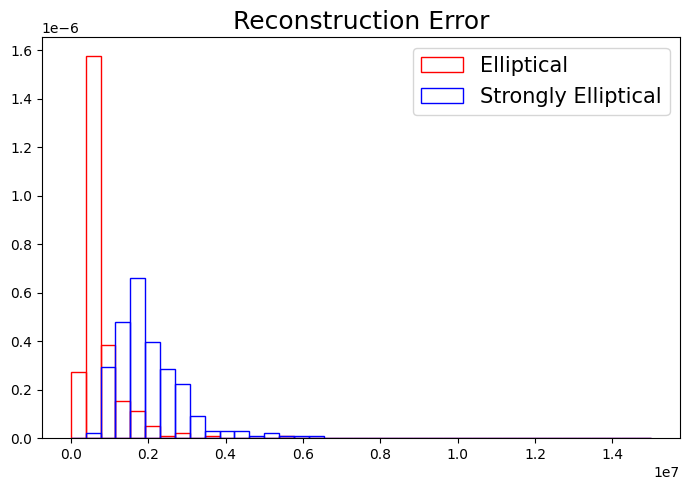

In [ ]:
params_dict = {'bins':np.linspace(0,1.5e+7,40),'density':True,'fill':False}
fig,ax = plt.subplots(1,figsize=(7,5))
ax.hist(reconstruct_error_train,**params_dict,edgecolor='red')
ax.hist(reconstruct_error_ve,**params_dict,edgecolor='blue')
ax.legend(['Elliptical','Strongly Elliptical'],fontsize=15)
ax.set_title('Reconstruction Error',fontsize=18)
#ax.tick_params(fontsize=15)
plt.tight_layout()
plt.show()



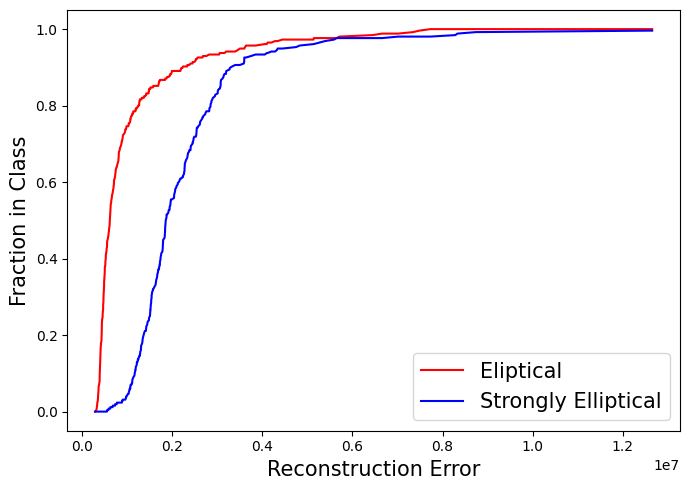

In [ ]:
re_error_total = list(reconstruct_error_train)+list(reconstruct_error_ve)
re_error_total.sort()
SE_prop = []
E_prop = []
for re_i in re_error_total:
  e_sum = np.sum(reconstruct_error_train<re_i)
  se_sum = np.sum(reconstruct_error_ve<re_i)
  SE_prop.append(se_sum/len(reconstruct_error_ve))
  E_prop.append(e_sum/len(reconstruct_error_train))

fig,ax = plt.subplots(1,figsize=(7,5))
plt.plot(re_error_total,E_prop,c='red')
plt.plot(re_error_total,SE_prop,c='blue')
#plt.title('Proportion of Images beyond threshold',fontsize=15)
plt.legend(['Eliptical','Strongly Elliptical'],fontsize=15)
#plt.xlim(right=0.4*1e+7)
plt.ylabel('Fraction in Class',fontsize=15)
plt.xlabel('Reconstruction Error',fontsize=15)
plt.tight_layout()
plt.show()